In [1]:
import pandas as pd

train = pd.read_csv('/kaggle/input/playground-series-s4e11/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e11/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e11/sample_submission.csv')

In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

In [3]:
numerical_columns = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress']

In [4]:
# Define a function to cap outliers in a column
def cap_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[column_name] = df[column_name].apply(
        lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x)
    )

# Apply the function to the train and test datasets
for column in numerical_columns:
    if column in train.columns:
        cap_outliers(train, column)
    if column in test.columns:
        cap_outliers(test, column)

In [5]:
# Fill NaN values in text columns with 'unknown'
text_columns = train.select_dtypes(include=['object']).columns
train[text_columns] = train[text_columns].fillna('unknown')

test_text_columns = test.select_dtypes(include=['object']).columns
test[test_text_columns] = test[test_text_columns].fillna('unknown')

In [6]:
# Fill NaN values in numeric columns with 0
numeric_columns = train.select_dtypes(include=['number']).columns
train[numeric_columns] = train[numeric_columns].fillna(0)

test_numeric_columns = test.select_dtypes(include=['number']).columns
test[test_numeric_columns] = test[test_numeric_columns].fillna(0)

In [7]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply LabelEncoder to text columns in train and test datasets
for column in text_columns:
    train[column] = label_encoder.fit_transform(train[column])

for column in test_text_columns:
    test[column] = label_encoder.fit_transform(test[column])

In [8]:
# Calculate correlation matrix for the train dataset
correlation_matrix = train.corr()

# Extract correlations with the 'Depression' column
correlation_with_depression = correlation_matrix['Depression'].sort_values(ascending=False)
correlation_with_depression

Depression                               1.000000
Academic Pressure                        0.586630
CGPA                                     0.511933
Study Satisfaction                       0.418999
Profession                               0.353820
Have you ever had suicidal thoughts ?    0.349066
Financial Stress                         0.227207
Work/Study Hours                         0.191746
Dietary Habits                           0.143445
Family History of Mental Illness         0.016502
Sleep Duration                           0.014454
Gender                                   0.008144
id                                       0.003944
City                                    -0.020915
Name                                    -0.028897
Degree                                  -0.045514
Work Pressure                           -0.258952
Job Satisfaction                        -0.434142
Working Professional or Student         -0.520790
Age                                     -0.564671


In [9]:
selected_features = [
    'Academic Pressure',
    'CGPA',
    'Study Satisfaction',
    'Profession',
    'Have you ever had suicidal thoughts ?',
    'Financial Stress',
    'Work/Study Hours',
    'Dietary Habits',
    'Family History of Mental Illness',
    'Sleep Duration',
    'Gender',
    'id'
]

In [10]:
# Split the train dataset into features (X) and target (y)
X = train[selected_features]
y = train['Depression']

# Split the test dataset into features (X_test)
X_test = test[selected_features]

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [12]:
# Encode target variable
y_encoded = LabelEncoder().fit_transform(y)

In [13]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import xgboost as xgb
import numpy as np

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Initialize the model
model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_encoded)))

accuracies = []

for train_index, val_index in kf.split(X):
    # Split the data into training and validation sets
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y_encoded[train_index], y_encoded[val_index]

    # Scale the features
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler.transform(X_val_fold)

    # Train the model
    model.fit(X_train_fold_scaled, y_train_fold)

    # Make predictions on the validation set
    y_val_pred = model.predict(X_val_fold_scaled)

    # Evaluate accuracy
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    accuracies.append(accuracy)

# Calculate the average accuracy
average_accuracy = np.mean(accuracies)
average_accuracy

0.9118479033404407

In [14]:
import pickle

# Save the trained model to a pickle file
with open('mental_health_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [15]:
# Predict on the test set
X_test_scaled = scaler.transform(X_test)
test_predictions = model.predict(X_test_scaled)

In [16]:
# Inverse transform
test_predictions_original = label_encoder.inverse_transform(test_predictions)

In [17]:
# Calculate the percentage of each class in the test predictions
unique, counts = np.unique(test_predictions_original, return_counts=True)
percentage_results = dict(zip(unique, (counts / len(test_predictions_original)) * 100))
percentage_results

{'No': 84.13965884861408, 'Yes': 15.86034115138593}

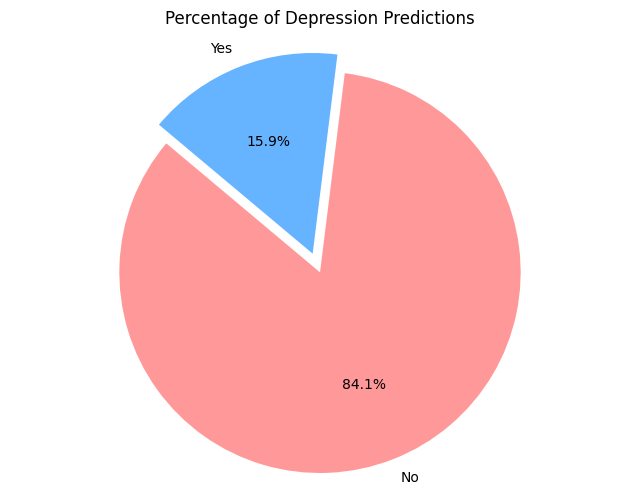

In [18]:
import matplotlib.pyplot as plt

# Visualize the percentage results
labels = percentage_results.keys()
sizes = percentage_results.values()
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  # explode the first slice

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Depression Predictions')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

- The predicted results for the mental health survey indicate that 84.14% of individuals are not experiencing depression, while 15.86% are experiencing depression.